## Real

In [1]:
from wiki_dataset import WikiDataset
from vector_database import VectorDatabase
from torch.utils.data import DataLoader
from fever_dataset import FeverDataset, FeverCollator
from embgen_gte import EmbeddingGenerator
from nli_16 import NLI_Heads_16M
from validation2 import Validation
from train2 import Train
from other_utils import print_progress
import torch
import json
import numpy as np
import time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
N_EPOCHS = 25
NUM_EXTRA_PAGES = 2000000

fever_collator = FeverCollator()
train_fever_dataset = FeverDataset(type='train')
train_fever_loader = DataLoader(train_fever_dataset, batch_size=len(train_fever_dataset), num_workers=1, shuffle=True, collate_fn=fever_collator, pin_memory=True)
eval_fever_dataset = FeverDataset(type='eval')
eval_fever_loader = DataLoader(eval_fever_dataset, len(eval_fever_dataset), num_workers=1, shuffle=False, collate_fn=fever_collator, pin_memory=True)
wiki_dataset = WikiDataset(reduced=True, in_mem=False, evidence=False, num_extra_pages=NUM_EXTRA_PAGES, seed=0)
wiki_dataloader = DataLoader(wiki_dataset, batch_size=10000, num_workers=8, shuffle=False, pin_memory=True)
evidence_dataset = WikiDataset(reduced=False, in_mem=True, evidence=True)
evidence_dataloader = DataLoader(evidence_dataset, batch_size=10000, num_workers=8, shuffle=False, pin_memory=True)

emb_gen = EmbeddingGenerator(device=device)
nli = NLI_Heads_16M(device=device)

loss_fn1 = torch.nn.CosineEmbeddingLoss(margin=0.25)
loss_fn2 = torch.nn.BCEWithLogitsLoss()

# a fussed optimizer
optimizer = torch.optim.AdamW([
    {'params': emb_gen.parameters(), 'lr': 5e-7},
    {'params': nli.parameters(), 'lr': 5e-5}
], fused=True)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.25, patience=0, verbose=True)


tracking_eval = {'nli_accuracy': [],
                'nli_f1': [],
                'overall_accuracy': [],
                'overall_f1': [],
                'conditional_accuracy': [],
                'conditional_f1': [],
                'average_enough_retrieved': [],
                'average_total_retrieved': [],
                'average_loss1': [],
                'average_loss2':  [],
                'average_total_loss': []}


tracking_train = {'nli_accuracy': [],
                'nli_f1': [],
                'overall_accuracy': [],
                'overall_f1': [],
                'conditional_accuracy': [],
                'conditional_f1': [],
                'average_enough_retrieved': [],
                'average_total_retrieved': [],
                'average_loss1': [],
                'average_loss2':  [],
                'average_total_loss': []}

In [2]:
#load the best models, optimizers, schedulers, and tracking dictionaries

emb_gen.load_state_dict(torch.load('models/emb_gen_v2.pth'))
nli.load_state_dict(torch.load('models/nli_v2.pth'))
optimizer.load_state_dict(torch.load('models/optimizer_v2.pth'))
scheduler.load_state_dict(torch.load('models/scheduler_v2.pth'))
with open('metrics/tracking_eval_v2.json', 'r') as f:
    tracking_eval = json.load(f)
with open('metrics/tracking_train_v2.json', 'r') as f:
    tracking_train = json.load(f)

avg_cond_f1 = []
for i in range(0, len(tracking_eval['conditional_f1']), 3):
    avg_cond_f1.append(np.mean(tracking_eval['conditional_f1'][i:i+3]))

Epoch: 2
Batch: 6463/9091


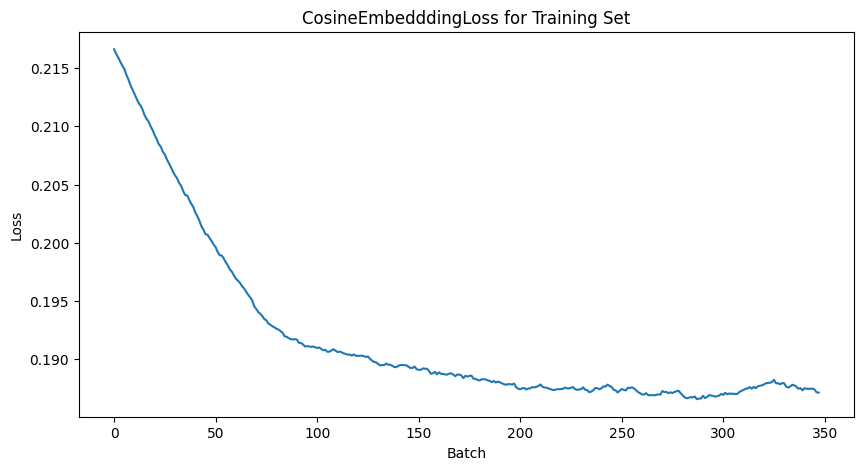

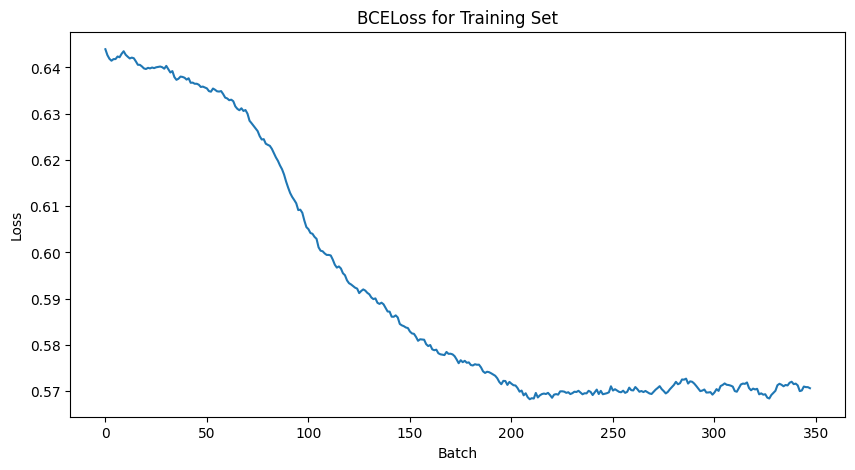

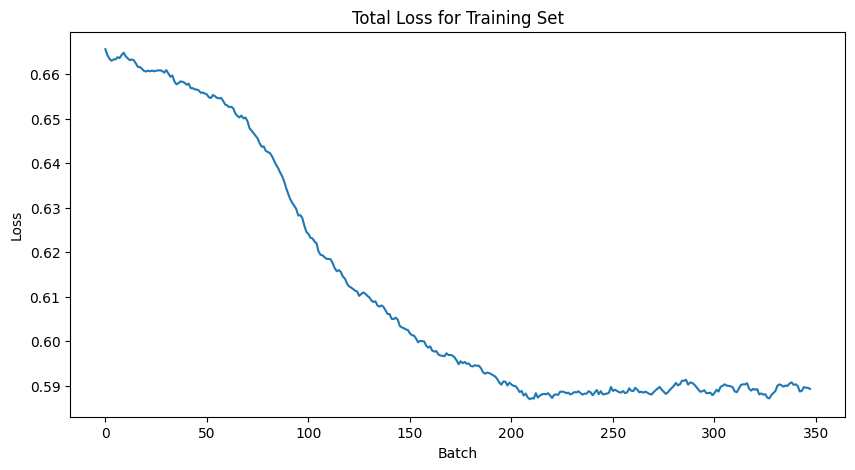

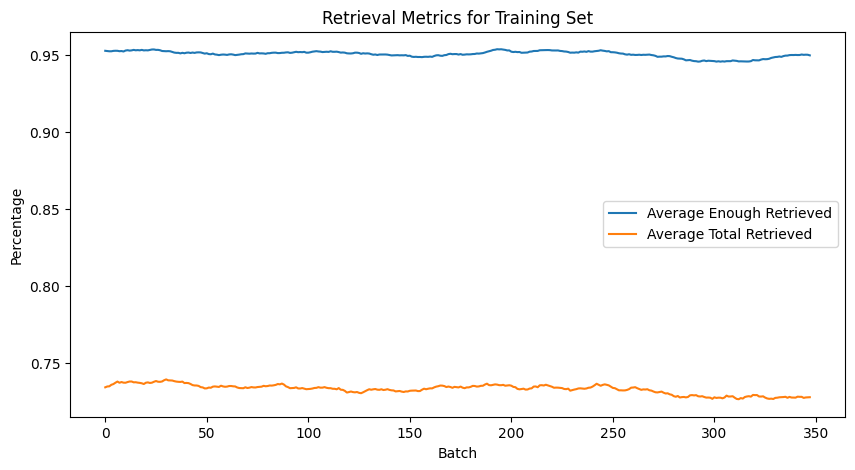

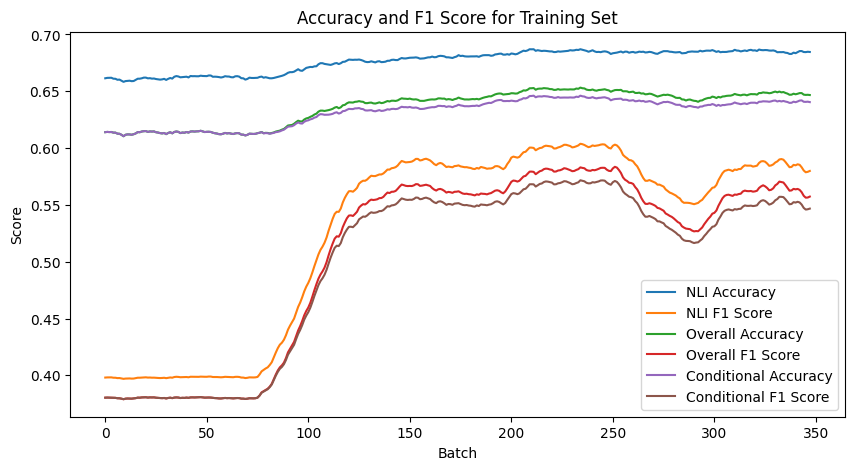

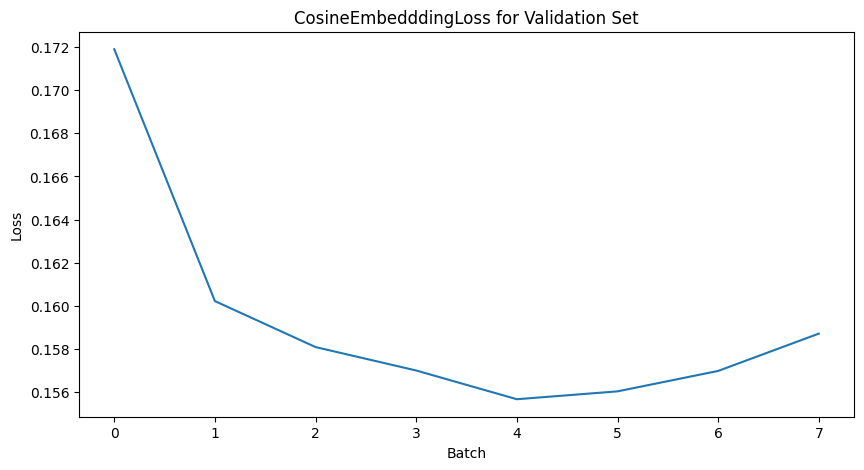

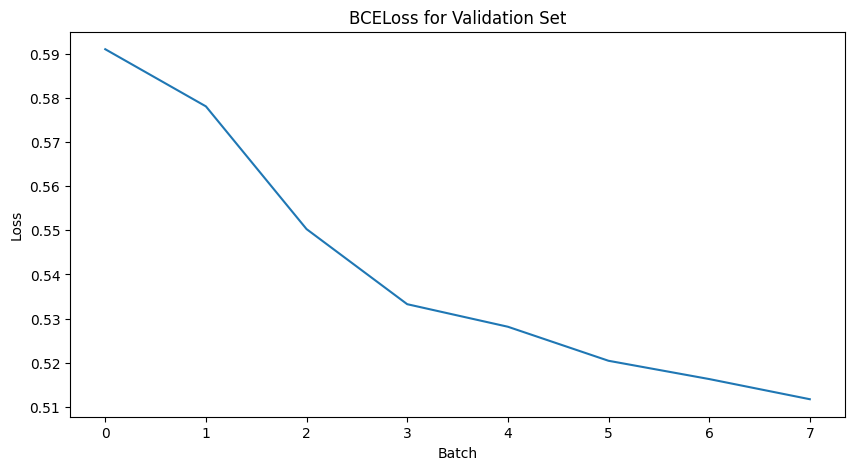

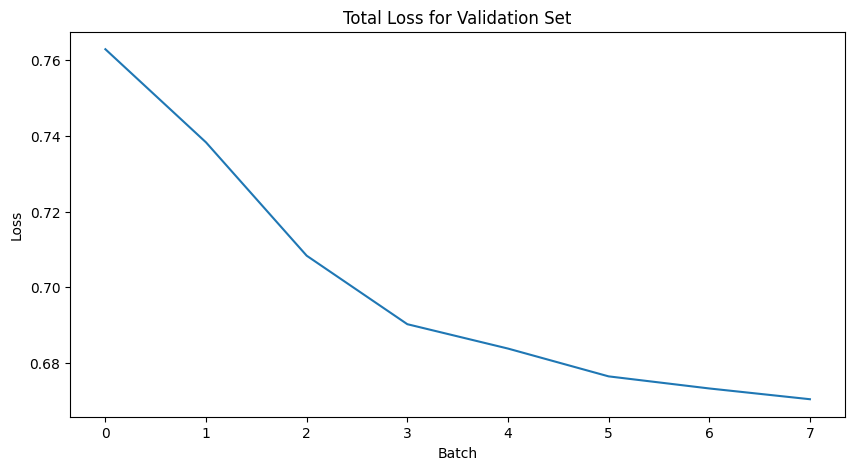

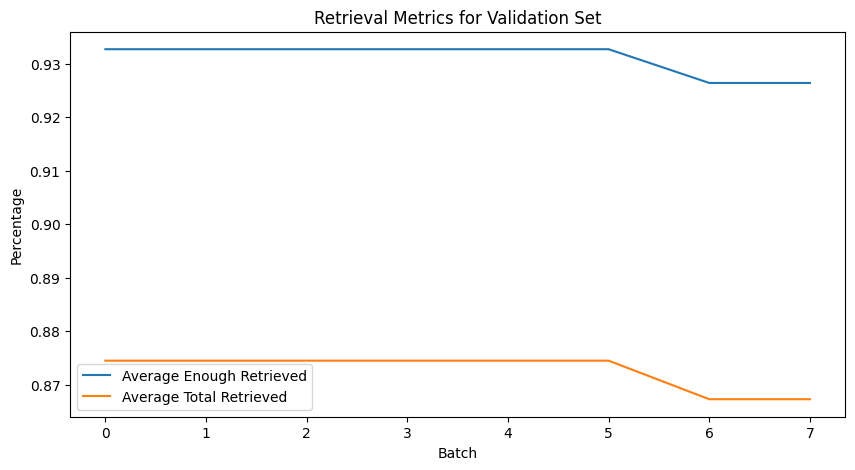

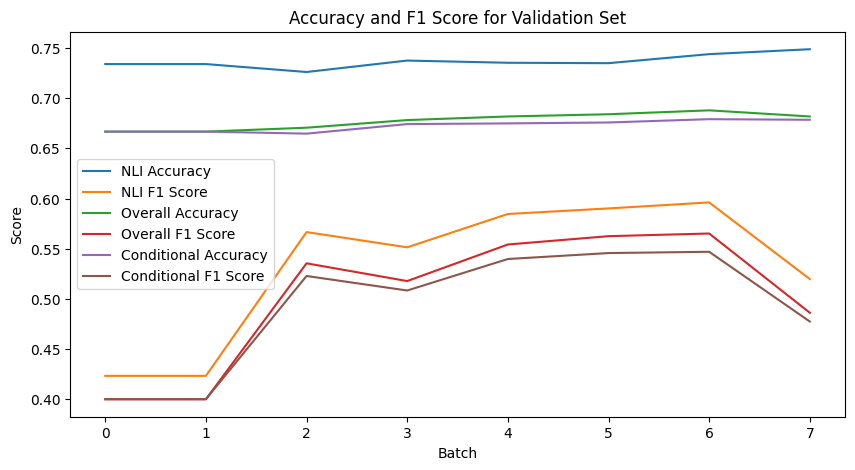

{'preds': [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 'original_labels': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 'dynamic_labels': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 'percentage_retrieved': [1.0, 0.5, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0], 'loss1': 0.22171032428741455, 'loss2': 0.37982404232025146, 'total_loss': 0.40199506282806396}
{'preds': [0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0], 'original_labels': [0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0], 'dynamic_labels': [0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0], 'percentage_retrieved': [0.0, 1.0, 0.0, 0.0, 0.25, 0.5, 1.0, 0.42857142857142855, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0], 'loss1': 0.2245517373085022, 'loss2': 0.7505471706390381, 'total_loss': 0.7730023264884949}
{'preds': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], 'original_labels': [1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0], 'dynamic_labels': [1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 

In [2]:
vdb = VectorDatabase(wiki_loader=wiki_dataloader, emb_gen=emb_gen, host='docker', version='v1')
evdb = VectorDatabase(wiki_loader=evidence_dataloader, emb_gen=emb_gen, host='docker', version='ve')

strike_one = False
avg_cond_f1 = []
for epoch in range(len(avg_cond_f1), N_EPOCHS):
    if epoch % 2 == 0:
        train = Train(device=device, train_loader=train_fever_loader, loss_fn1=loss_fn1, loss_fn2=loss_fn2, optimizer=optimizer, vdb=vdb, evdb=evdb, emb_gen=emb_gen)
        val = Validation(device=device, eval_loader=eval_fever_loader, loss_fn1=loss_fn1, loss_fn2=loss_fn2, vdb=vdb, emb_gen=emb_gen)
        
    train.train_epoch(epoch=epoch, emb_gen=emb_gen, nli=nli, val=val, tracking_train=tracking_train, tracking_eval=tracking_eval, super_batch=64, ma_ratio=0.1)
    val.valid_epoch(emb_gen=emb_gen, nli=nli, tracking_eval=tracking_eval)

    scheduler.step(np.mean(tracking_eval['average_total_loss'][-3:]))

    print_progress(epoch=0, batch=1, num_total_batches=1, tracking_train=tracking_train, tracking_eval=tracking_eval, ma_ratio=0.1)
    
    # save the metrics
    with open('metrics/tracking_train_v3.json', 'w') as f:
        json.dump(tracking_train, f)
    with open('metrics/tracking_eval_v3.json', 'w') as f:
        json.dump(tracking_eval, f)
        
    # save the model if it is the best one, return True if it is not to stop the training
    avg_cond_f1.append(np.mean(tracking_eval['conditional_f1'][-3:]))
    if avg_cond_f1[-1] == max(avg_cond_f1):
        torch.save(emb_gen.state_dict(), 'models/emb_gen_v3.pth')
        torch.save(nli.state_dict(), 'models/nli_v3.pth')
        torch.save(optimizer.state_dict(), 'models/optimizer_v3.pth')
        torch.save(scheduler.state_dict(), 'models/scheduler_v3.pth')
        strike_one = False
    else:
        torch.save(emb_gen.state_dict(), 'models/emb_gen_v3_latest.pth')
        torch.save(nli.state_dict(), 'models/nli_v3_latest.pth')
        torch.save(optimizer.state_dict(), 'models/optimizer_v3_latest.pth')
        torch.save(scheduler.state_dict(), 'models/scheduler_v3_latest.pth')
        if strike_one:
            break
        strike_one = True

    if epoch % 2 == 1:
        vdb.refresh(emb_gen, 'vx', delete=False)
        evdb.refresh(emb_gen, 'vex', delete=False)
        time.sleep(600)

# Test

In [3]:
## load the models
emb_gen.load_state_dict(torch.load('models/emb_gen_v1.pth'))
nli.load_state_dict(torch.load('models/nli_v1.pth'))

<All keys matched successfully>

In [19]:
# evaluate on the test set
tracking_test = {'nli_accuracy': [],
                'nli_f1': [],
                'overall_accuracy': [],
                'overall_f1': [],
                'conditional_accuracy': [],
                'conditional_f1': [],
                'average_enough_retrieved': [],
                'average_total_retrieved': [],
                'average_loss1': [],
                'average_loss2':  [],
                'average_total_loss': []}

test_fever_dataset = FeverDataset(type='test')
test_fever_loader = DataLoader(test_fever_dataset, len(test_fever_dataset), num_workers=1, shuffle=False, collate_fn=fever_collator, pin_memory=True)
test = Validation(device=device, eval_loader=test_fever_loader, loss_fn1=loss_fn1, loss_fn2=loss_fn2, vdb=vdb, emb_gen=emb_gen)
test.valid_epoch(emb_gen=emb_gen, nli=nli, tracking_eval=tracking_test)
print(tracking_test)

{'nli_accuracy': [0.689018901890189, 0.697919791979198, 0.6999199919992], 'nli_f1': [0.6366351521755622, 0.6381960657065836, 0.6379964580495132], 'overall_accuracy': [0.6668666866686669, 0.673967396739674, 0.6722172217221722], 'overall_f1': [0.6321445465961149, 0.6324102551241131, 0.6281690430889518], 'average_enough_retrieved': [0.9275427542754275, 0.92994299429943, 0.9305930593059306], 'average_total_retrieved': [0.8520910000451714, 0.8555006267221252, 0.8583384105005029], 'average_loss1': [0.27073885709904255, 0.26886292382741506, 0.2676309596616239], 'average_loss2': [0.5781226050549041, 0.5953079941935433, 0.6365552734071835], 'average_total_loss': [0.848861460868543, 0.8641709174972754, 0.9041862341161734]}


In [20]:
# with open('metrics/tracking_test_v1.json', 'w') as f:
#     json.dump(tracking_test, f)

# NLI Test

In [1]:
%load_ext autoreload
%autoreload 2
from wiki_dataset import WikiDataset
from vector_database import VectorDatabase
from torch.utils.data import DataLoader
from fever_dataset import FeverDataset, FeverCollator
from embgen_gte import EmbeddingGenerator
from nli_16 import NLI_FullLinear_16M, NLI_PairsBasic_16M, NLI_Heads_16M, NLI_MiniHeads_16M
from nli_4 import NLI_FullLinear_4M, NLI_PairsBasic_4M, NLI_Heads_4M, NLI_MiniHeads_4M
from NLI_tests.validation2 import Validation
from NLI_tests.train2 import Train
from NLI_tests.other_utils import print_progress
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
N_EPOCHS = 7
NUM_EXTRA_PAGES = 0

fever_collator = FeverCollator()
train_fever_dataset = FeverDataset(type='train')
train_fever_loader = DataLoader(train_fever_dataset, batch_size=len(train_fever_dataset), num_workers=1, shuffle=True, collate_fn=fever_collator, pin_memory=True)
eval_fever_dataset = FeverDataset(type='eval')
eval_fever_loader = DataLoader(eval_fever_dataset, len(train_fever_dataset), num_workers=1, shuffle=False, collate_fn=fever_collator, pin_memory=True)
wiki_dataset = WikiDataset(reduced=False, in_mem=False, num_extra_pages=NUM_EXTRA_PAGES, seed=0)
wiki_dataloader = DataLoader(wiki_dataset, batch_size=10000, num_workers=4, shuffle=False, pin_memory=True)
evidence_dataset = WikiDataset(reduced=False, in_mem=True, evidence=True, num_extra_pages=NUM_EXTRA_PAGES, seed=0)
evidence_dataloader = DataLoader(evidence_dataset, batch_size=10000, num_workers=8, shuffle=False, pin_memory=True)

emb_gen = EmbeddingGenerator(device=device)
nli = [NLI_FullLinear_16M(device=device), NLI_PairsBasic_16M(device=device), NLI_Heads_16M(device=device), NLI_MiniHeads_16M(device=device),
       NLI_FullLinear_4M(device=device), NLI_PairsBasic_4M(device=device), NLI_Heads_4M(device=device), NLI_MiniHeads_4M(device=device)]

loss_fn2 = torch.nn.BCEWithLogitsLoss()

# a fussed optimizer
optimizer = torch.optim.AdamW([
    {'params': nli[i].parameters(), 'lr': 5e-5} for i in range(len(nli))
], fused=True)


tracking_eval = {'nli_f1': [],
                'nli_accuracy': [], 
                'average_enough_retrieved': [],
                'average_total_retrieved': [],
                'average_loss2':  [],}


tracking_train = {'nli_f1': [],
                 'nli_accuracy': [], 
                 'average_enough_retrieved': [],
                 'average_total_retrieved': [],
                 'average_loss2':  [],}

In [3]:
vdb = VectorDatabase(wiki_loader=wiki_dataloader, emb_gen=emb_gen, host='docker', version='v1')
evdb = VectorDatabase(wiki_loader=evidence_dataloader, emb_gen=emb_gen, host='docker', version='ve')

val = Validation(device=device, eval_loader=eval_fever_loader, loss_fn2=loss_fn2, vdb=vdb, emb_gen=emb_gen)
train = Train(device=device, train_loader=train_fever_loader, loss_fn2=loss_fn2, optimizer=optimizer, vdb=vdb, evdb=evdb, emb_gen=emb_gen)

Creating collection
Block 1/542 done
Block 2/542 done
Block 3/542 done
Block 4/542 done
Block 5/542 done
Block 6/542 done
Block 7/542 done
Block 8/542 done
Block 9/542 done
Block 10/542 done
Block 11/542 done
Block 12/542 done
Block 13/542 done
Block 14/542 done
Block 15/542 done
Block 16/542 done
Block 17/542 done
Block 18/542 done
Block 19/542 done
Block 20/542 done
Block 21/542 done
Block 22/542 done
Block 23/542 done
Block 24/542 done
Block 25/542 done
Block 26/542 done
Block 27/542 done
Block 28/542 done
Block 29/542 done
Block 30/542 done
Block 31/542 done
Block 32/542 done
Block 33/542 done
Block 34/542 done
Block 35/542 done
Block 36/542 done
Block 37/542 done
Block 38/542 done
Block 39/542 done
Block 40/542 done
Block 41/542 done
Block 42/542 done
Block 43/542 done
Block 44/542 done
Block 45/542 done
Block 46/542 done
Block 47/542 done
Block 48/542 done
Block 49/542 done
Block 50/542 done
Block 51/542 done
Block 52/542 done
Block 53/542 done
Block 54/542 done
Block 55/542 done

Epoch: 5
Batch: 3199/9091


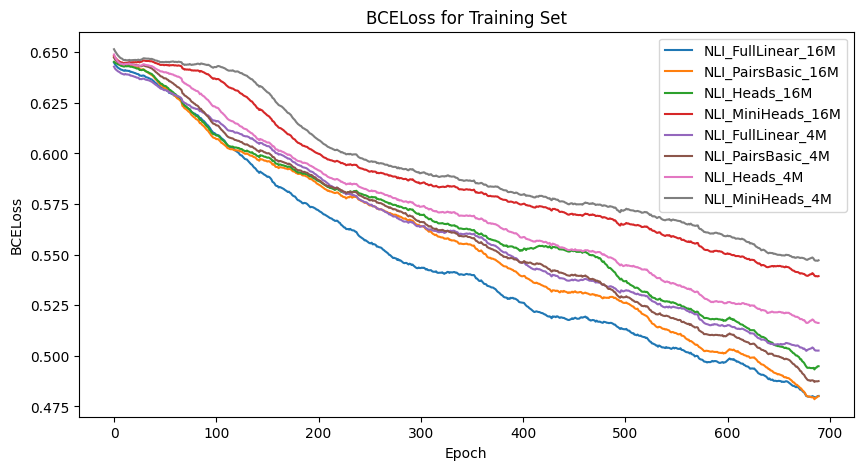

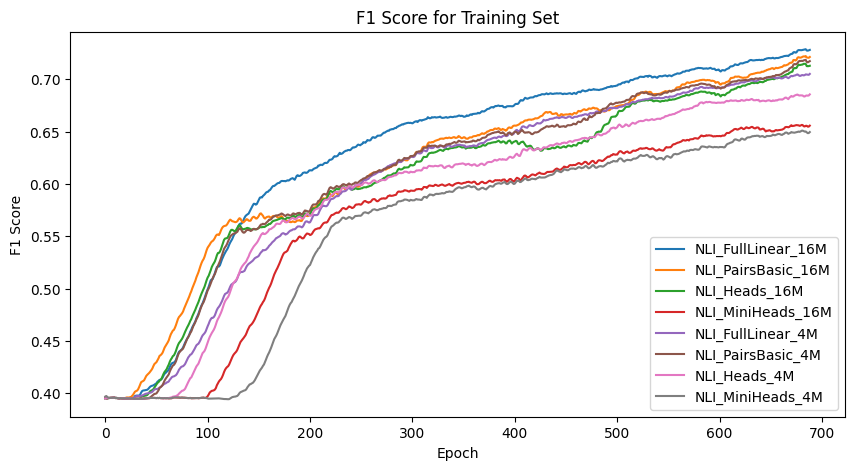

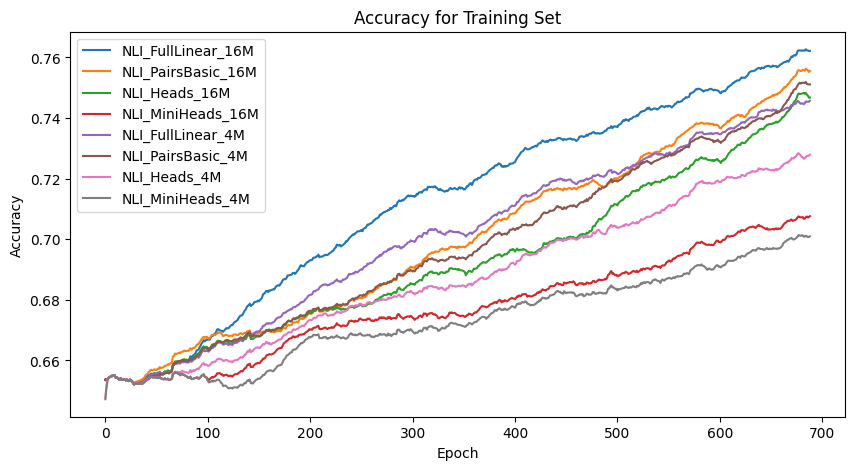

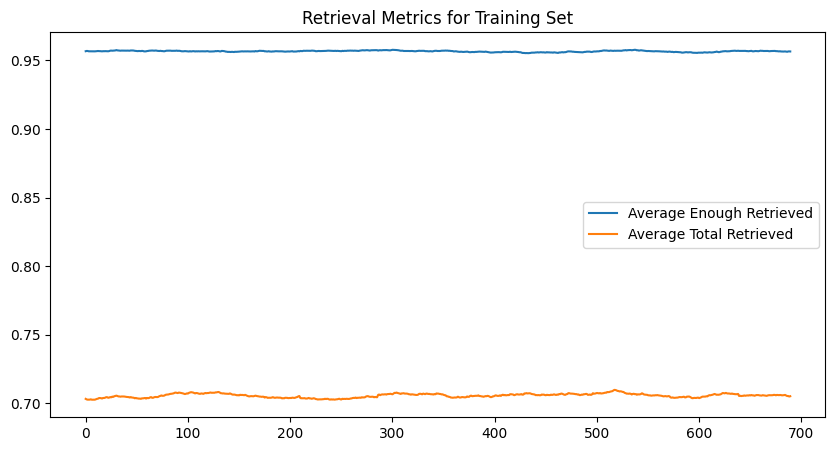

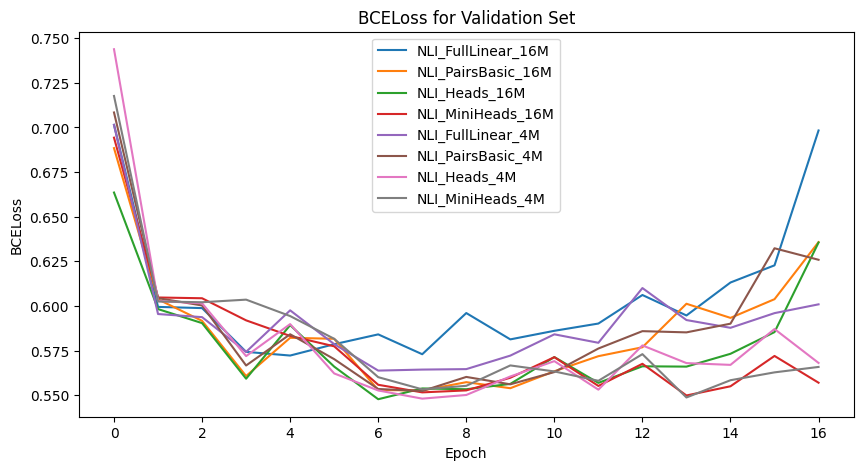

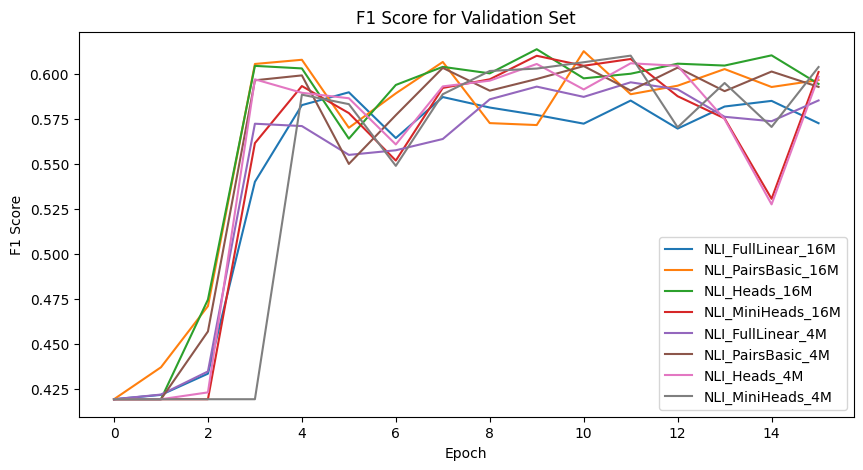

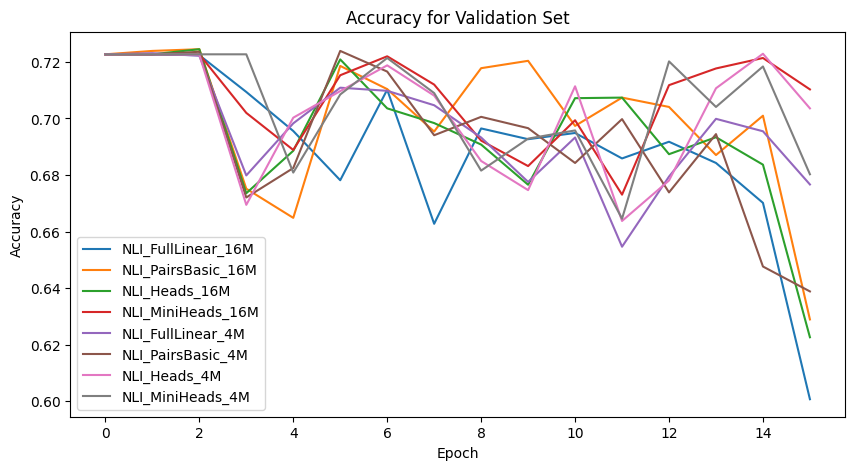

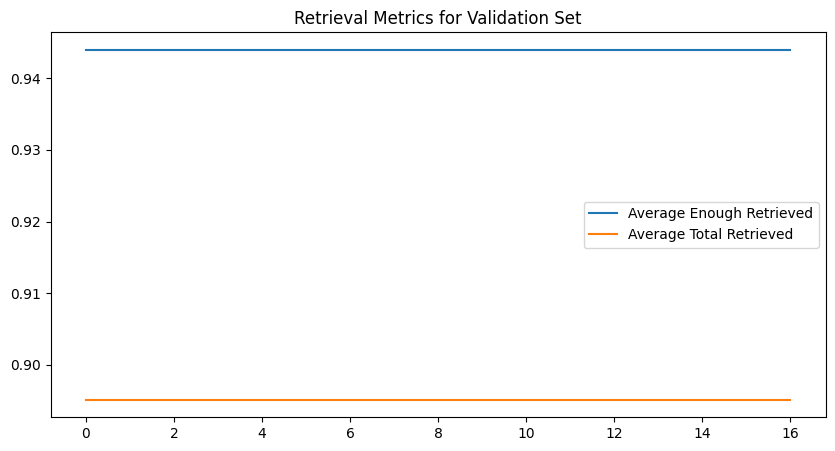

{'preds': [[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'original_labels': [0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0], 'dynamic_labels': [0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0], 'percentage_retrieved': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.3333333333333333, 1.0, 1.0, 0.0], 'loss2': [0.44974565505981445, 0.4223039746284485, 0.4558529853820801, 0.4895284175872803, 0.44235891103744507, 0.41972658038139343, 0.4979788064956665, 0.49887439608573914]}
{'preds': [[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0

KeyboardInterrupt: 

In [4]:
val.valid_epoch(emb_gen=emb_gen, nli=nli, tracking_eval=tracking_eval)
for epoch in range(N_EPOCHS):
    train.train_epoch(epoch=epoch, emb_gen=emb_gen, nli=nli, val=val, tracking_train=tracking_train, tracking_eval=tracking_eval, super_batch=64, ma_ratio=0.1)
    print_progress(epoch=0, batch=1, num_total_batches=1, tracking_train=tracking_train, tracking_eval=tracking_eval, ma_ratio=0.1)
    val.valid_epoch(emb_gen=emb_gen, nli=nli, tracking_eval=tracking_eval)
    print_progress(epoch=0, batch=1, num_total_batches=1, tracking_train=tracking_train, tracking_eval=tracking_eval, ma_ratio=0.1)

In [5]:
import json

with open('NLI_tests/results/tracking_train_v16_v4_4.json', 'w') as f:
    json.dump(tracking_train, f)

with open('NLI_tests/results/tracking_eval_v16_v4_4.json', 'w') as f:
    json.dump(tracking_eval, f)

In [7]:
from NLI_tests.validation2 import Validation
from NLI_tests.train_eval_utils2 import get_metrics

# evaluate on the test set
tracking_test = {'nli_accuracy': [],
                'nli_f1': [],
                'overall_accuracy': [],
                'overall_f1': [],
                'conditional_accuracy': [],
                'conditional_f1': [],
                'average_enough_retrieved': [],
                'average_total_retrieved': [],
                'average_loss2':  []}

test_fever_dataset = FeverDataset(type='test')
test_fever_loader = DataLoader(test_fever_dataset, len(test_fever_dataset), num_workers=1, shuffle=False, collate_fn=fever_collator, pin_memory=True)
test = Validation(device=device, eval_loader=test_fever_loader, loss_fn2=loss_fn2, vdb=vdb, emb_gen=emb_gen)
test.valid_epoch(emb_gen=emb_gen, nli=nli, tracking_eval=tracking_test)
print(tracking_test)

{'nli_accuracy': [[0.6805680568056806, 0.7112711271127112, 0.7029702970297029, 0.6892689268926893, 0.6714671467146714, 0.6994699469946994, 0.6919691969196919, 0.6857685768576858]], 'nli_f1': [[0.5530420809441412, 0.545561224810267, 0.5251350222521276, 0.5995924353268411, 0.5754069601313797, 0.5763727027534622, 0.5903010843207444, 0.5974752795379425]], 'overall_accuracy': [], 'overall_f1': [], 'conditional_accuracy': [], 'conditional_f1': [], 'average_enough_retrieved': [0.9568956895689569], 'average_total_retrieved': [0.9211475909495711], 'average_loss2': [[0.6431639232453267, 0.6228185595980116, 0.6282088991942679, 0.5742994763289287, 0.612988141501785, 0.6145768581302302, 0.5865006985937714, 0.5722556376153496]]}
